In [1]:
import numpy as np

My implementation of C-T algorithm

In [2]:
def w_n(n):
    return np.exp(-2j*np.pi/n)

def my_fft(X):
    N = len(X)
    if N == 1:
        return X
    elif N == 2:
        Y1 = X[0] + X[1]
        Y2 = X[0] - X[1]
        Y = np.append(Y1,Y2)
        return Y
    else:
        i = np.arange(N/2)
        w = w_n(N)**i
        W = np.diag(w)
        even = X[0:N-1:2]
        odd = X[1:N:2]
        Y1 = my_fft(even)
        Y2 = my_fft(odd)
        WY2 = np.dot(W,Y2)
        Y3 = Y1 + WY2
        Y4 = Y1 - WY2
        Y = np.append(Y3,Y4)
    return Y

Inverse FFT

In [95]:
def my_ifft(X):
    N = len(X)
    if N == 1:
        return X
    elif N == 2:
        Y1 = (X[0] + X[1])/2
        Y2 = (X[0] - X[1])/2
        Y = np.append(Y1,Y2)
        return Y
    else:
        i = np.arange(N/2)
        w = np.conj(w_n(N)**i)
        W = np.diag(w)
        even = X[0:N-1:2]
        odd = X[1:N:2]
        Y1 = my_ifft(even)
        Y2 = my_ifft(odd)
        WY2 = np.dot(W,Y2)
        p = np.log2(N)
        Y3 = (Y1 + WY2)
        Y4 = (Y1 - WY2)
        Y = np.append(Y3,Y4)
        Y = 2**(p-1)*Y/N
    return Y

#Test
N = 128
X = 2*np.random.randn(N,)
myY = my_ifft(X)
npY = np.fft.ifft(X)

print 'Relative error =', (np.linalg.norm(myY - npY)) / np.linalg.norm(npY)

Relative error = 2.1421709333e-15


Convertion to circulant matrix

In [96]:
def convert_to_circulant(c,r):
    r_reverse = r[:0:-1]
    new_c = np.append(c,[0])
    new_c = np.append(new_c,r_reverse)
    return new_c

In [97]:
from scipy.linalg import toeplitz

Multiplication by general Toeplitz matrix

In [98]:
def my_toeplitz(c,r,X):
    N = len(X)
    c = convert_to_circulant(c,r)
    X_new = np.append(X,np.zeros(N,))
    #Y = my_ifft(my_fft(c)*my_fft(X_new))
    Y = np.fft.ifft(np.fft.fft(c)*np.fft.fft(X_new))
    return Y[:N]


#Test
N = 4
c = 2*np.random.rand(N,)
r = 3*np.random.rand(N,)
X = 2*np.random.rand(N,)

T1 = np.dot(toeplitz(c,r),X)
T2 = my_toeplitz(c,r,X)

print 'Relative error =', (np.linalg.norm(T1 - T2)) / np.linalg.norm(T1)

Relative error = 1.42525349007e-16


The specific filter

In [99]:
def my_convolution_1D(X):
    N = len(X)
    alfa = 1./20.
    i = np.arange(N)
    t = np.sqrt(alfa/np.pi)*np.exp(-alfa*i*i)
    T = my_toeplitz(t,t,X)
    return T


Playing the signal

In [100]:
#Tech stuff
from scipy.io import wavfile
from scipy.signal import resample
import numpy as np
%matplotlib inline
import sys
def load_wav(filename,samplerate=44100):
    
    # load file
    rate, data = wavfile.read(filename)

    # convert stereo to mono
    if len(data.shape) > 1:
        data = data[:,0]/2 + data[:,1]/2

    # re-interpolate samplerate    
    ratio = float(samplerate) / float(rate)
    data = resample(data, len(data) * ratio)
    
    return samplerate, data.astype(np.int16)

In [101]:
#Reading the wavefile
import StringIO
import base64
import struct  

from IPython.core.display import HTML
from IPython.core.display import display
def wavPlayer(data, rate):
    """ will display html 5 player for compatible browser
    The browser need to know how to play wav through html5.
    there is no autoplay to prevent file playing when the browser opens
    Adapted from SciPy.io. and
    github.com/Carreau/posts/blob/master/07-the-sound-of-hydrogen.ipynb
    """
    
    buffer = StringIO.StringIO()
    buffer.write(b'RIFF')
    buffer.write(b'\x00\x00\x00\x00')
    buffer.write(b'WAVE')

    buffer.write(b'fmt ')
    if data.ndim == 1:
        noc = 1
    else:
        noc = data.shape[1]
    bits = data.dtype.itemsize * 8
    sbytes = rate*(bits // 8)*noc
    ba = noc * (bits // 8)
    buffer.write(struct.pack('<ihHIIHH', 16, 1, noc, rate, sbytes, ba, bits))

    # data chunk
    buffer.write(b'data')
    buffer.write(struct.pack('<i', data.nbytes))

    if data.dtype.byteorder == '>' or (data.dtype.byteorder == '=' and sys.byteorder == 'big'):
        data = data.byteswap()

    buffer.write(data.tostring())
    # return buffer.getvalue()
    # Determine file size and place it in correct
    # position at start of the file.
    size = buffer.tell()
    buffer.seek(4)
    buffer.write(struct.pack('<i', size-8))
    
    val = buffer.getvalue()
    
    src = """
    <head>
    <meta http-equiv="Content-Type" content="text/html; charset=utf-8">
    <title>Simple Test</title>
    </head>
    
    <body>
    <audio controls="controls" style="width:600px" >
      <source controls src="data:audio/wav;base64,{base64}" type="audio/wav" />
      Your browser does not support the audio element.
    </audio>
    </body>
    """.format(base64=base64.encodestring(val))
    display(HTML(src))

Original signal

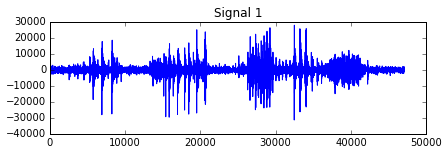

In [102]:
#The first sound
import pylab as pl
import numpy as np
# load
fs1,s1 = load_wav('TPhYes01.wav') # Terran SCV: "Come again, captain?"

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Signal 1')
pl.show()

# player
wavPlayer(s1, fs1)

Convolution of the signal

47106


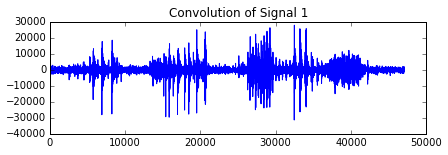

C:\Users\frike\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:13: ComplexWarning: Casting complex values to real discards the imaginary part


In [103]:
# convolution 
N = len(s1)
print N
s2 = my_convolution_1D(s1)

# plot
pl.figure(figsize=(6.75,2))
pl.plot(s1)
pl.title('Convolution of Signal 1')
pl.show()

# player
wavPlayer(s2.astype(np.int16), fs1)

2D part

In [105]:
from scipy import misc

In [167]:
lena = misc.lena()
n = len(lena)
alpha = 1.0/50.

T = [[alpha / np.pi * np.exp(-alpha*(i**2 + j**2)) 
      for j in range(n) + range(-n+1, 0)] 
     for i in range(n) + range(-n+1, 0)]

zeros_right = [[0]*n]*(n-1)
zeros_bottom = [[0]*(n-1)]*(2*n-1)
wide_lena = np.concatenate((lena,zeros_right))
wide_lena = np.concatenate((wide_lena,zeros_bottom),axis = 1)

filtered_lena = np.fft.ifft2(np.multiply(np.fft.fft2(T),np.fft.fft2(wide_lena)))

C:\Users\frike\AppData\Local\Continuum\Anaconda\lib\site-packages\ipykernel\__main__.py:3: ComplexWarning: Casting complex values to real discards the imaginary part
  app.launch_new_instance()


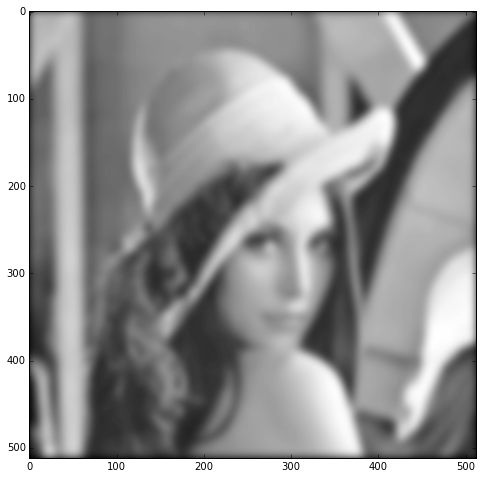

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline
filtered_lena = filtered_lena.astype(np.int64)[:n, :n]
plt.figure(figsize=(8,8))
plt.imshow(filtered_lena)